<h1>PART A: GAN</h1>

<h2>Importing Libraries</h2>

<hr>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from scipy.linalg import sqrtm
import seaborn as sns

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

<h2>Load Dataset</h2>
<hr>

In [2]:
df = pd.read_csv('emnist-letters-train.csv', sep=',', header=None)

<h2> Exploratory Data Analysis(EDA) <h2>
<hr>

In [3]:
df.values.shape

(99040, 785)

In [5]:
df

0    1    2    3    4    5    6    7    8    9    ...  775  776  777  \
0       23    0    0    0    0    0    0    0    0    0  ...    0    0    0   
1        7    0    0    0    0    0    0    0    0    0  ...    0    0    0   
2       16    0    0    0    0    0    0    0    0    0  ...    0    0    0   
3       15    0    0    0    0    0    0    0    0    0  ...    0    0    0   
4       23    0    0    0    0    0    0    0    0    0  ...    0    0    0   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
99035   18    0    0    0    0    0    0    0    0    0  ...    0    0    0   
99036   24    0    0    0    0    0    0    0    0    0  ...    0    0    0   
99037   19    0    0    0    0    0    0    0    0    0  ...    0    0    0   
99038   -1  174  174  174  174  174  174  174  174  174  ...  174  174  174   
99039   -1   42   42   42   42   42   42   42   42   42  ...   42   42   42   

       778  779  780  781  782  783  784  
0        0    0    0    0    0    0    0  
1        0    0    0    0    0    0    0  
2        0    0    0    0    0    0    0  
3        0    0    0    0    0    0    0  
4        0    0    0    0    0    0    0  
...    ...  ...  ...  ...  ...  ...  ...  
99035    0    0    0    0    0    0    0  
99036    0    0    0    0    0    0    0  
99037    0    0    0    0    0    0    0  
99038  174  174  174  174  174  174  174  
99039   42   42   42   42   42   42   42  

[99040 rows x 785 columns]

We can see that the first column of the dataset is used for classes

In [4]:
np.sort(df[0].unique())

array([-1,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26], dtype=int64)

As we can see, there are a total of 27 classes ranging from -1 to 26, excluding 0

We can take a look at what each class represents by getting a image sample from each class and displaying it.

In [28]:
def show_images(images, rows = 3, cols = 9, show_headers = True, show_plot = True):
    # Example array with multiple images (4 grayscale images of size 100x100)
    num_images = len(images)

    # Plotting all images in a grid
    fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

    for i in range(num_images):
        r = i // cols
        c = i % cols
        
        if i < 27 and show_headers:
            a = np.sort(df[0].unique())[i]
        else:
            a = ''

        axes[r][c].imshow(images[i], cmap='gray')
        axes[r][c].axis('off')
        axes[r][c].set_title(f'{a}')

    plt.tight_layout()

    if show_plot:
        plt.show()
    else:
        return plt

In [8]:
images = []

for i in np.sort(df[0].unique()):
    images.append(df[df[0] == i].sample().values[0][1:].reshape(28,28))

<h3> Visualising Sample Images <h3>

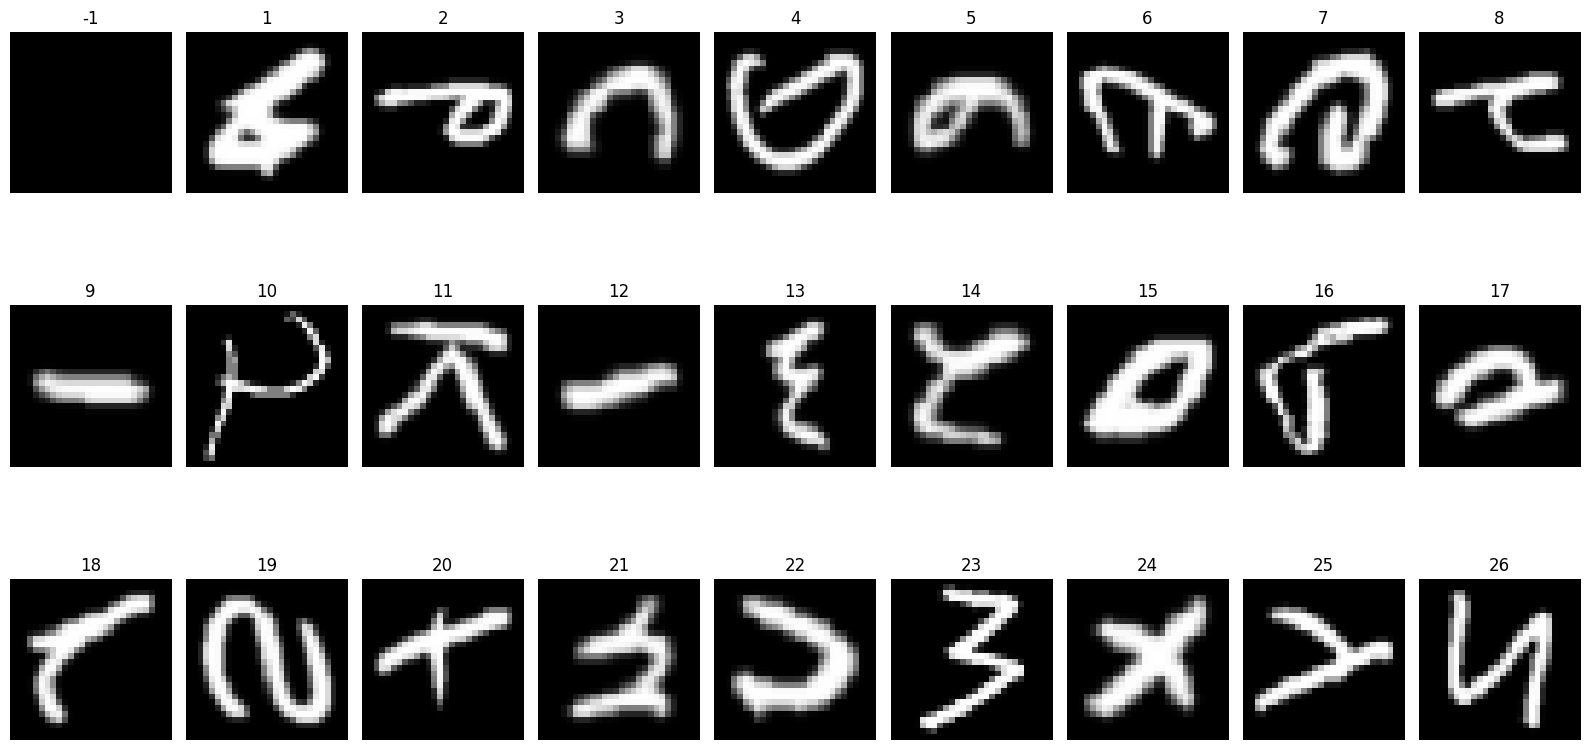

In [9]:
show_images(images)

As we can see, each class seems to represent a specific letter but, it is distorted and we would need to augment the data to make it appear normal

In [10]:
mirrored_image = []

for i in images:
    mirrored_image.append(np.flip(i, axis=1))

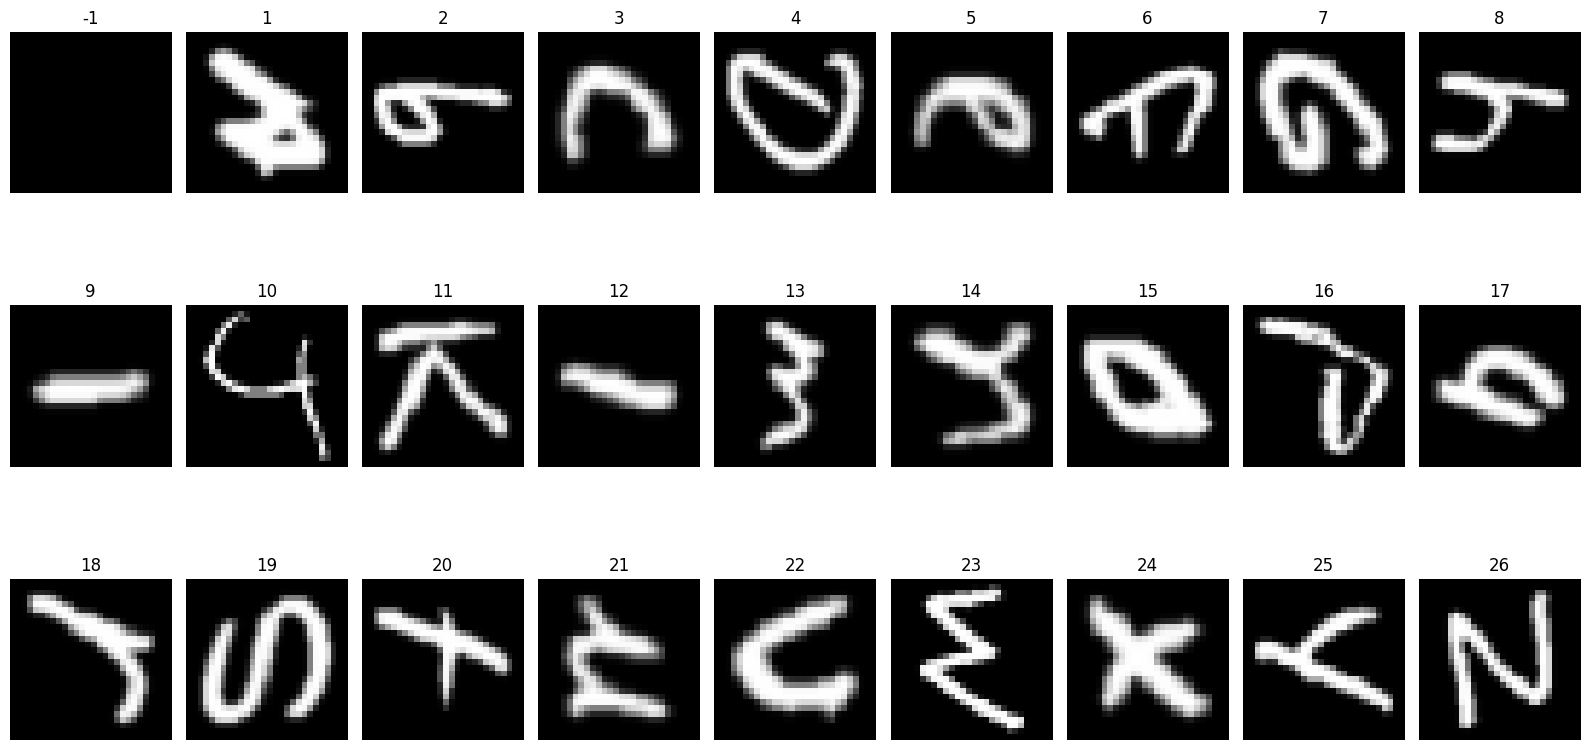

In [11]:
show_images(mirrored_image)

After mirroring the images, we can see that the letters look rotated. We can undo this by rotating it 90 degrees anti-clockwise

In [12]:
rotated_image = []

for i in mirrored_image:
    rotated_image.append(np.rot90(i, k=1))

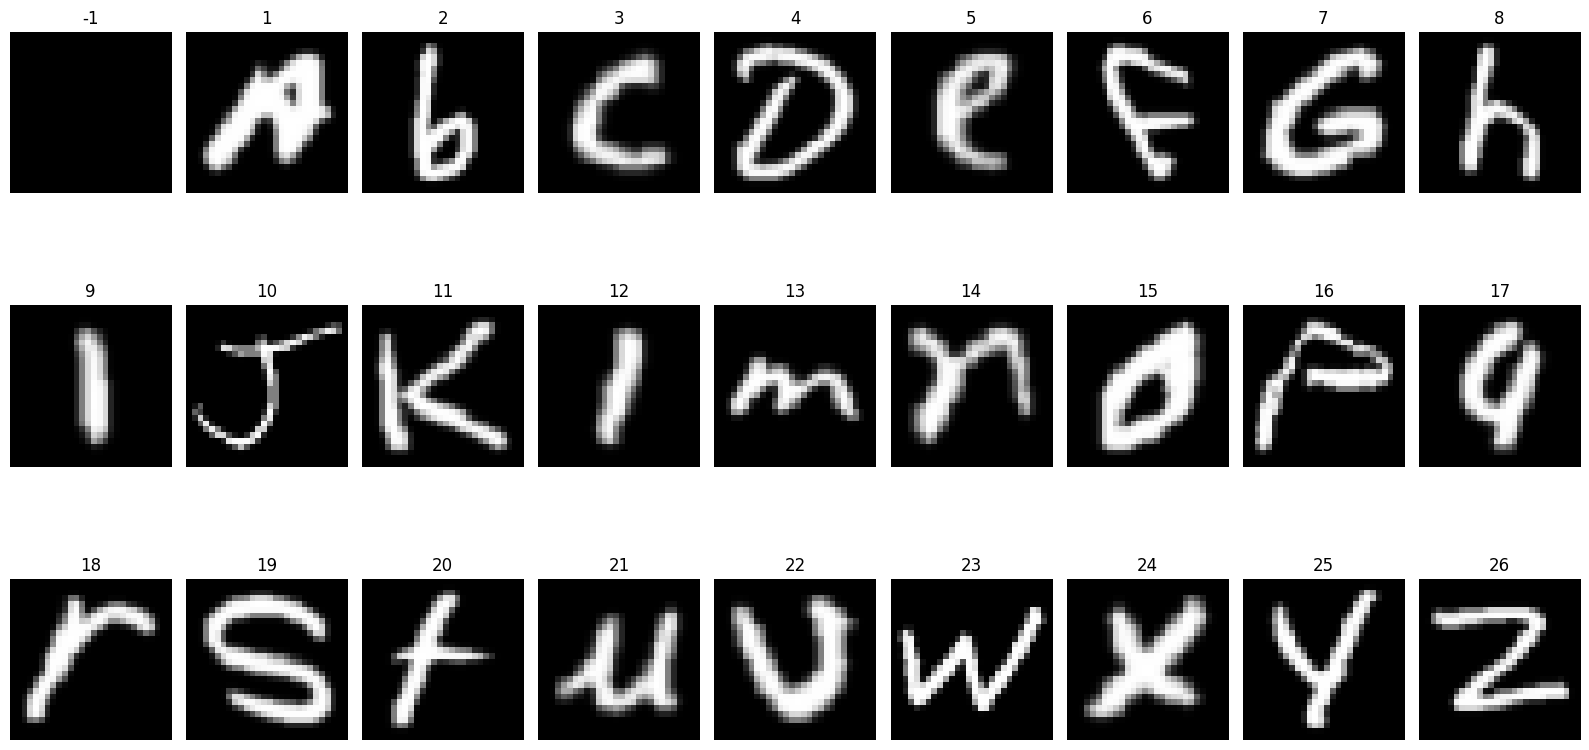

In [13]:
show_images(rotated_image)

The images now look normal and we have found the transformations needed to make it look normal.

<h3> Dataset Understanding - Image Dimensions <h3>

In [14]:
images[0].shape

(28, 28)

The dimensions of our images is 28x28 pixels


<h3> Statistical Analysis & Data Distribution<h3>

Mean pixel value: 52.559373789398634
Standard deviation of pixel values: 87.1699250607223


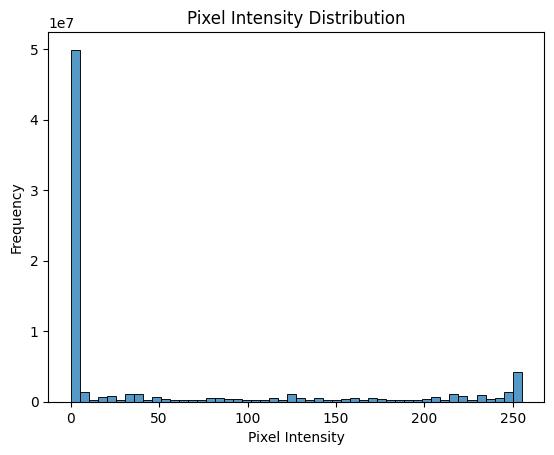

In [15]:
flattened_images = df.iloc[:, 1:].values.flatten()

# Calculate mean and standard deviation of pixel values
mean_pixel_value = np.mean(flattened_images)
std_pixel_value = np.std(flattened_images)

print(f"Mean pixel value: {mean_pixel_value}")
print(f"Standard deviation of pixel values: {std_pixel_value}")

# Plot histogram of pixel intensities
# plt.hist(flattened_images, bins=50, range=[0, 255])
# plt.title('Pixel Intensity Distribution')
# plt.xlabel('Pixel Intensity')
# plt.ylabel('Frequency')
# plt.show()
sns.histplot(flattened_images, bins=50, binrange=[0, 255], kde=False)
plt.title('Pixel Intensity Distribution')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()

<u><b>Observation</b></u><br>
The plot peaks at intensity value 0 indicating a common intensity level across our dataset, this is because most of the pixels that make up our image are black in colour (pixel value: 0)<br>
We also notice a slightly higher frequency in the right end of the histogram, this is because the alphabets in our images are made up of bright pixels which have a high pixel value, close to 255<br>
Frequency shown in the middle of our histogram between the two ends mentioned is low and uniform 

<h3>Class Imbalance Analysis<h3>

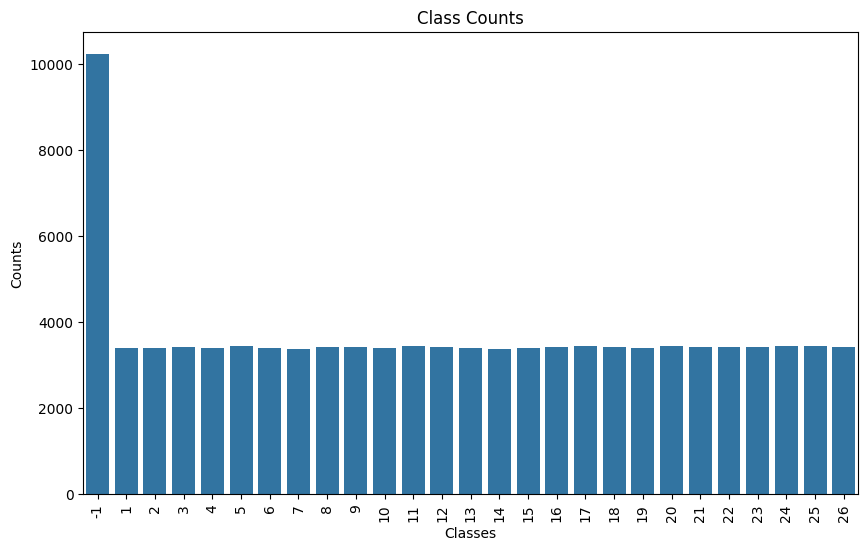

In [16]:
class_counts = df[0].value_counts().sort_index()
class_labels = [f'{np.sort(df[0].unique())[i]}' for i in range(len(np.sort(df[0].unique())))]

# Convert to DataFrame for Seaborn compatibility
class_counts_df = pd.DataFrame({'Class': class_labels, 'Count': class_counts.values})

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='Class', y='Count', data=class_counts_df)
plt.xlabel('Classes')
plt.ylabel('Counts')
plt.title('Class Counts')
plt.xticks(rotation=90)
plt.show()

We can see a class imbalance in our dataset, having a significant difference between the class -1 and the rest of the classes. The rest of the classes are more or less balanced

In [17]:
df[df[0] == -1].sample(27).iloc[:,1:]

1    2    3    4    5    6    7    8    9    10   ...  775  776  777  \
59137   67   67   67   67   67   67   67   67   67   67  ...   67   67   67   
23042  154  154  154  154  154  154  154  154  154  154  ...  154  154  154   
48263  200  200  200  200  200  200  200  200  200  200  ...  200  200  200   
17632  110  110  110  110  110  110  110  110  110  110  ...  110  110  110   
36605   45   45   45   45   45   45   45   45   45   45  ...   45   45   45   
61168  108  108  108  108  108  108  108  108  108  108  ...  108  108  108   
48842   42   42   42   42   42   42   42   42   42   42  ...   42   42   42   
98250    3    3    3    3    3    3    3    3    3    3  ...    3    3    3   
63982   91   91   91   91   91   91   91   91   91   91  ...   91   91   91   
36609  209  209  209  209  209  209  209  209  209  209  ...  209  209  209   
183     77   77   77   77   77   77   77   77   77   77  ...   77   77   77   
46165   18   18   18   18   18   18   18   18   18   18  ...   18   18   18   
45429   80   80   80   80   80   80   80   80   80   80  ...   80   80   80   
94413  117  117  117  117  117  117  117  117  117  117  ...  117  117  117   
63361  218  218  218  218  218  218  218  218  218  218  ...  218  218  218   
80653   54   54   54   54   54   54   54   54   54   54  ...   54   54   54   
46027   36   36   36   36   36   36   36   36   36   36  ...   36   36   36   
11638  112  112  112  112  112  112  112  112  112  112  ...  112  112  112   
89986  152  152  152  152  152  152  152  152  152  152  ...  152  152  152   
15203   31   31   31   31   31   31   31   31   31   31  ...   31   31   31   
12509  190  190  190  190  190  190  190  190  190  190  ...  190  190  190   
83265   66   66   66   66   66   66   66   66   66   66  ...   66   66   66   
14989  130  130  130  130  130  130  130  130  130  130  ...  130  130  130   
13240    6    6    6    6    6    6    6    6    6    6  ...    6    6    6   
36416  117  117  117  117  117  117  117  117  117  117  ...  117  117  117   
7322   154  154  154  154  154  154  154  154  154  154  ...  154  154  154   
21829  250  250  250  250  250  250  250  250  250  250  ...  250  250  250   

       778  779  780  781  782  783  784  
59137   67   67   67   67   67   67   67  
23042  154  154  154  154  154  154  154  
48263  200  200  200  200  200  200  200  
17632  110  110  110  110  110  110  110  
36605   45   45   45   45   45   45   45  
61168  108  108  108  108  108  108  108  
48842   42   42   42   42   42   42   42  
98250    3    3    3    3    3    3    3  
63982   91   91   91   91   91   91   91  
36609  209  209  209  209  209  209  209  
183     77   77   77   77   77   77   77  
46165   18   18   18   18   18   18   18  
45429   80   80   80   80   80   80   80  
94413  117  117  117  117  117  117  117  
63361  218  218  218  218  218  218  218  
80653   54   54   54   54   54   54   54  
46027   36   36   36   36   36   36   36  
11638  112  112  112  112  112  112  112  
89986  152  152  152  152  152  152  152  
15203   31   31   31   31   31   31   31  
12509  190  190  190  190  190  190  190  
83265   66   66   66   66   66   66   66  
14989  130  130  130  130  130  130  130  
13240    6    6    6    6    6    6    6  
36416  117  117  117  117  117  117  117  
7322   154  154  154  154  154  154  154  
21829  250  250  250  250  250  250  250  

[27 rows x 784 columns]

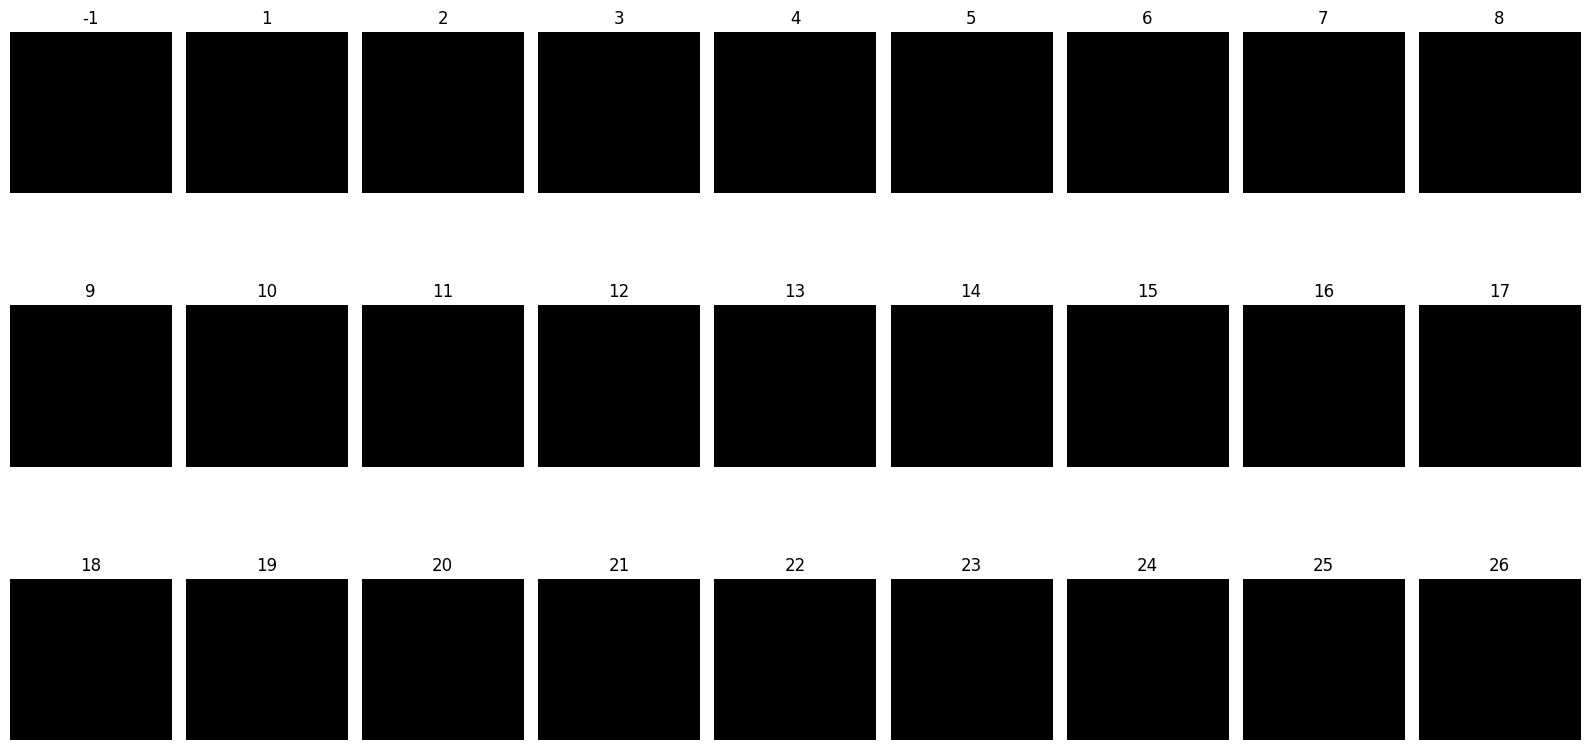

In [18]:
show_images(df[df[0] == -1].sample(27).iloc[:,1:].values.reshape(-1,28,28))

In [5]:
class_neg1_df = df[df[0] == -1].iloc[:,1:]

In [6]:
class_neg1_df.values

array([[ 89,  89,  89, ...,  89,  89,  89],
       [216, 216, 216, ..., 216, 216, 216],
       [ 74,  74,  74, ...,  74,  74,  74],
       ...,
       [132, 132, 132, ..., 132, 132, 132],
       [174, 174, 174, ..., 174, 174, 174],
       [ 42,  42,  42, ...,  42,  42,  42]], dtype=int64)

In [7]:
for i in class_neg1_df.values:
    if len(np.unique(i)) > 1:
        print(np.unique(i))

We can conclude that all the values in each array is the same and as we can see, of a sample of 27 images, it seems to be that all images are pure black, so we remove class -1. These images are likely not meaningful and can negatively affect the training process of the GAN. Including them could lead to the model learning undesirable features or wasting capacity on irrelevant data.

<h2>Initial Modelling <h2>
<hr>

We will now apply the same transformation to the whole image dataset. 

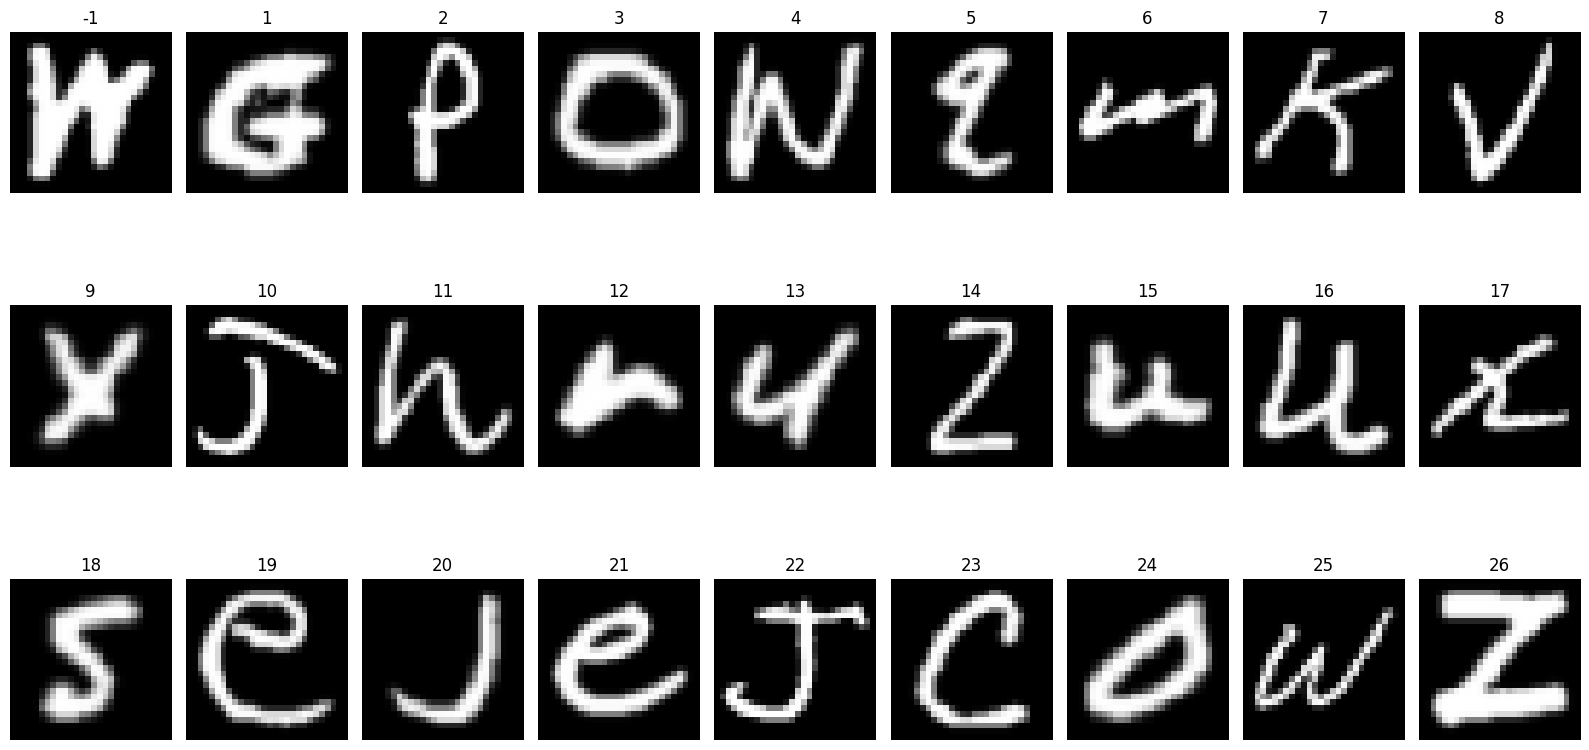

In [10]:
# Copy the original df into a new df
input_df = df.copy()

# Remove images with class label -1
input_df = input_df[input_df[0] != -1]

# Remove the first column to get only the pixel values
input_df = input_df.drop(0, axis=1)

# Convert the dataframe into a numpy array
input_data = input_df.values

# Reshape the data into 28x28 images
input_data = input_data.reshape(-1, 28, 28)

# Flip the images horizontally
input_data = np.flip(input_data, axis=2)

# Rotate the images 90 degrees
input_data = np.rot90(input_data, k=1, axes=(1, 2))

# Plot the first 27 images
show_images(input_data[:27])

We have now transformed our images to be aligned properly and can now make sense of it<br>
Now we can use these images as our train dataset


In [11]:
random_selection_size = 10000

random_indices = np.random.choice(input_data.shape[0], random_selection_size, replace=False)
random_selected_input_data = input_data[random_indices]

# Re-scale to 0-1
random_selected_input_data_rescaled = random_selected_input_data / 255.0
flattened_random_selected_input_data_rescaled = np.array([sub_array.flatten() for sub_array in random_selected_input_data_rescaled])
flattened_random_selected_input_data_rescaled.shape

(10000, 784)

In [12]:
# Re-scale to 0-1
input_data_rescaled = input_data / 255.0
flattened_input_data_rescaled = np.array([sub_array.flatten() for sub_array in input_data_rescaled])
flattened_input_data_rescaled.shape

(88800, 784)

In [13]:
# calculate frechet inception distance
def calculate_fid(act1, act2):
	# calculate mean and covariance statistics
	mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
	mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
	# calculate sum squared difference between means
	ssdiff = np.sum((mu1 - mu2)**2.0)
	# calculate sqrt of product between cov
	covmean = sqrtm(sigma1.dot(sigma2))
	# check and correct imaginary numbers from sqrt
	if np.iscomplexobj(covmean):
		covmean = covmean.real
	# calculate score
	fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
	return fid

<h3> Base Model <h3>

In [25]:
class Base_DCGAN():
    def __init__(self, rows, cols, channels, z = 10):
        # Input shape
        self.img_rows = rows
        self.img_cols = cols
        self.channels = channels
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = z

        self.discriminator_loss = []
        self.discriminator_accuracy = []
        self.generator_loss = []
        self.sample_fid_score = []
        self.broad_fid_score = []
        self.epochs = []
        self.broad_fid_epochs = []

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(128 * 7 * 7, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((7, 7, 128)))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Conv2D(self.channels, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))

        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=256, save_interval=50, broad_fid_interval=1000):

        # Load the dataset
        X_train = input_data

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Train the generator (wants discriminator to mistake images as real)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if (epoch % save_interval == 0) or (epoch == epochs-1):
                self.discriminator_loss.append(d_loss[0])
                self.discriminator_accuracy.append(100*d_loss[1])
                self.generator_loss.append(g_loss)
                self.sample_fid_score.append(self.get_sample_fid())
                self.epochs.append(epoch)
                self.save_imgs(epoch)
                if (epoch % broad_fid_interval == 0) or (epoch == epochs-1):
                    self.broad_fid_score.append(self.get_broad_fid())
                    self.broad_fid_epochs.append(epoch)

    def get_sample_fid(self):
        generated_images = self.generate_image(random_selection_size)
        flattened_generated_images = np.array([sub_array.flatten() for sub_array in generated_images])
        fid = calculate_fid(flattened_random_selected_input_data_rescaled, flattened_generated_images)
        return fid
    
    def get_broad_fid(self):
        generated_images = self.generate_image(input_data.shape[0])
        flattened_generated_images = np.array([sub_array.flatten() for sub_array in generated_images])
        fid = calculate_fid(flattened_input_data_rescaled, flattened_generated_images)
        return fid

    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1

        os.makedirs('base_training_images', exist_ok=True)

        fig.savefig("base_training_images/dcgan_mnist_{:d}.png".format(epoch))
        plt.close()

    def generate_image(self, num_of_images):
        noise = np.random.normal(0, 1, (num_of_images, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        return gen_imgs

In [26]:
base_dcgan = Base_DCGAN(28,28,1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 32)        320       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 32)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 zero_padding2d (ZeroPadding  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 8, 8, 64)         256       
 ormalization)                                          

In [27]:
base_dcgan.train(epochs=1000, batch_size=256, save_interval=50, broad_fid_interval=100)

8/8 [==============================] - 4s 1ms/step
0 [D loss: 1.036790, acc.: 35.55%] [G loss: 0.696222]
8/8 [==============================] - 0s 3ms/step
1 [D loss: 0.998998, acc.: 51.37%] [G loss: 0.714890]
8/8 [==============================] - 0s 2ms/step
2 [D loss: 0.450679, acc.: 80.47%] [G loss: 0.697273]
8/8 [==============================] - 0s 2ms/step
3 [D loss: 0.339541, acc.: 86.72%] [G loss: 0.549814]
8/8 [==============================] - 0s 1ms/step
4 [D loss: 0.272410, acc.: 91.41%] [G loss: 0.302465]
8/8 [==============================] - 0s 1ms/step
5 [D loss: 0.212801, acc.: 93.16%] [G loss: 0.126343]
8/8 [==============================] - 0s 1ms/step
6 [D loss: 0.134946, acc.: 98.44%] [G loss: 0.036243]
8/8 [==============================] - 0s 1ms/step
7 [D loss: 0.117000, acc.: 97.85%] [G loss: 0.009065]
8/8 [==============================] - 0s 1ms/step
8 [D loss: 0.116666, acc.: 97.66%] [G loss: 0.002707]
8/8 [==============================] - 0s 997us/step
9 

In [28]:
base_dcgan.epochs

[0,
 50,
 100,
 150,
 200,
 250,
 300,
 350,
 400,
 450,
 500,
 550,
 600,
 650,
 700,
 750,
 800,
 850,
 900,
 950,
 999]

<h3> Final Model <h3>

In [14]:
class DCGAN():
    def __init__(self, rows, cols, channels, z = 100):
        # Input shape
        self.img_rows = rows
        self.img_cols = cols
        self.channels = channels
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = z

        self.discriminator_loss = []
        self.discriminator_accuracy = []
        self.generator_loss = []
        self.sample_fid_score = []
        self.broad_fid_score = []
        self.epochs = []
        self.broad_fid_epochs = []

        optimizer = Adam(0.003, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=Adam(0.001, 0.5),
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer) # using MSE as it squares the error and is more particular about the error made, minimising pixel-level differences and getting a more accurate image 

    def save_generator(self):
        self.generator.save_weights("generator_weights.h5")

    def build_generator(self):

        model = Sequential()
        
        # Part B (best)
        model.add(Dense(7*7*256, use_bias=False, input_dim=self.latent_dim))
        model.add(BatchNormalization())
        model.add(LeakyReLU())

        model.add(Reshape((7, 7, 256)))
        model.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
        model.add(BatchNormalization())
        model.add(LeakyReLU())

        model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
        model.add(BatchNormalization())
        model.add(LeakyReLU())

        model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Conv2D(128, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.2))

        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))

        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.2))
        
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=256, save_interval=50, broad_fid_interval=1000):

        # Load the dataset
        X_train = input_data

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Train the generator (wants discriminator to mistake images as real)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if (epoch % save_interval == 0) or (epoch == epochs-1):
                self.discriminator_loss.append(d_loss[0])
                self.discriminator_accuracy.append(100*d_loss[1])
                self.generator_loss.append(g_loss)
                self.sample_fid_score.append(self.get_sample_fid())
                self.epochs.append(epoch)
                self.save_imgs(epoch)
                if (epoch % broad_fid_interval == 0) or (epoch == epochs-1):
                    self.broad_fid_score.append(self.get_broad_fid())
                    self.broad_fid_epochs.append(epoch)

    def get_sample_fid(self):
        generated_images = self.generate_image(random_selection_size)
        flattened_generated_images = np.array([sub_array.flatten() for sub_array in generated_images])
        fid = calculate_fid(flattened_random_selected_input_data_rescaled, flattened_generated_images)
        return fid
    
    def get_broad_fid(self):
        generated_images = self.generate_image(input_data.shape[0])
        flattened_generated_images = np.array([sub_array.flatten() for sub_array in generated_images])
        fid = calculate_fid(flattened_input_data_rescaled, flattened_generated_images)
        return fid


    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        
        os.makedirs('training_images', exist_ok=True)
        os.makedirs('generator_weights', exist_ok=True)
        os.makedirs('discriminator_weights', exist_ok=True)

        self.discriminator.save_weights("discriminator_weights/discriminator_weights_{:d}.h5".format(epoch))
        self.generator.save_weights("generator_weights/generator_weights_{:d}.h5".format(epoch))

        fig.savefig("training_images/dcgan_mnist_{:d}.png".format(epoch))
        plt.close()
    
    def generate_image(self, num_of_images):
        noise = np.random.normal(0, 1, (num_of_images, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        return gen_imgs


In [30]:
dcgan = DCGAN(28,28,1)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 14, 14, 128)       1280      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                                 
 dropout_4 (Dropout)         (None, 14, 14, 128)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 7, 7, 128)         147584    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_5 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 conv2d_9 (Conv2D)           (None, 4, 4, 128)        

In [31]:
dcgan.train(epochs=50000, batch_size=256, save_interval=50, broad_fid_interval=1000)

8/8 [==============================] - 0s 2ms/step
0 [D loss: 0.705763, acc.: 15.04%] [G loss: 0.634383]
8/8 [==============================] - 0s 1ms/step
1 [D loss: 0.591024, acc.: 50.00%] [G loss: 0.406350]
8/8 [==============================] - 0s 2ms/step
2 [D loss: 0.404334, acc.: 85.35%] [G loss: 0.109438]
8/8 [==============================] - 0s 2ms/step
3 [D loss: 0.389167, acc.: 50.00%] [G loss: 0.063541]
8/8 [==============================] - 0s 1ms/step
4 [D loss: 0.882492, acc.: 50.00%] [G loss: 0.420341]
8/8 [==============================] - 0s 1ms/step
5 [D loss: 0.632041, acc.: 50.00%] [G loss: 0.947421]
8/8 [==============================] - 0s 1ms/step
6 [D loss: 0.533940, acc.: 95.70%] [G loss: 0.685027]
8/8 [==============================] - 0s 1ms/step
7 [D loss: 0.439338, acc.: 92.58%] [G loss: 0.400848]
8/8 [==============================] - 0s 1ms/step
8 [D loss: 0.854061, acc.: 50.00%] [G loss: 0.923717]
8/8 [==============================] - 0s 1ms/step
9 [D

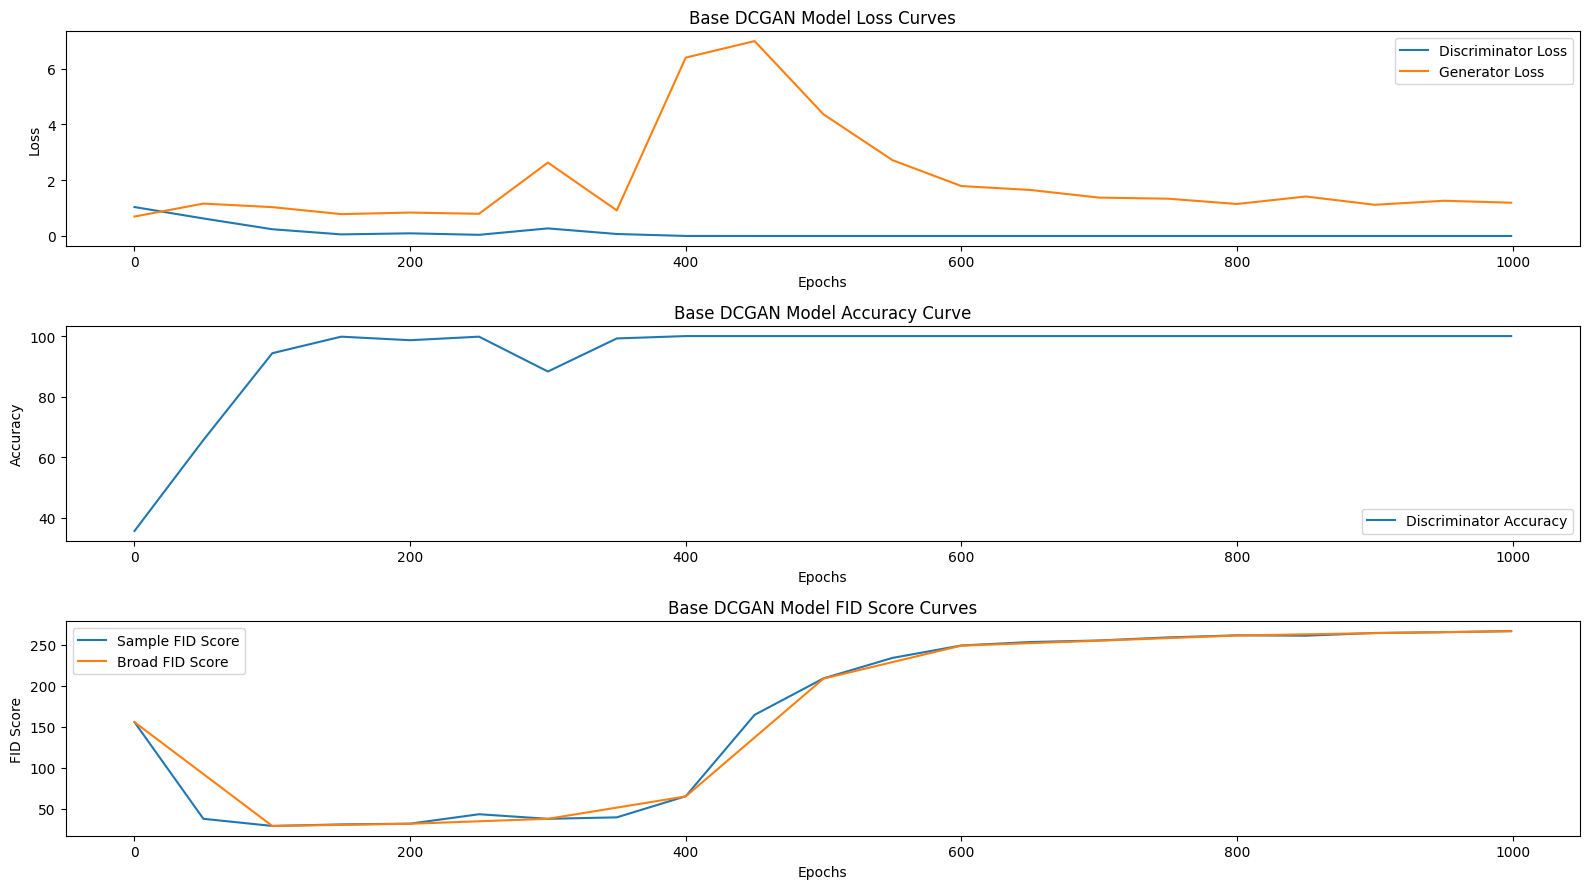

In [32]:
fig, ax = plt.subplots(3, 1, figsize=(16, 9))

ax[0].set_title('Base DCGAN Model Loss Curves')
ax[0].plot(base_dcgan.epochs, base_dcgan.discriminator_loss, label='Discriminator Loss')
ax[0].plot(base_dcgan.epochs, base_dcgan.generator_loss, label='Generator Loss')
ax[0].yaxis.set_label_text('Loss')
ax[0].xaxis.set_label_text('Epochs')
ax[0].legend()

ax[1].set_title('Base DCGAN Model Accuracy Curve')
ax[1].plot(base_dcgan.epochs, base_dcgan.discriminator_accuracy, label='Discriminator Accuracy')
ax[1].yaxis.set_label_text('Accuracy')
ax[1].xaxis.set_label_text('Epochs')
ax[1].legend()

ax[2].set_title('Base DCGAN Model FID Score Curves')
ax[2].plot(base_dcgan.epochs, base_dcgan.sample_fid_score, label='Sample FID Score')
ax[2].plot(base_dcgan.broad_fid_epochs, base_dcgan.broad_fid_score, label='Broad FID Score')
ax[2].yaxis.set_label_text('FID Score')
ax[2].xaxis.set_label_text('Epochs')
ax[2].legend()

fig.tight_layout()
plt.show()

In [33]:
print(f"Base DCGAN model final FID score at epoch {base_dcgan.broad_fid_epochs[-1]} is {base_dcgan.broad_fid_score[-1]}")

Base DCGAN model final FID score at epoch 999 is 266.2837686074784


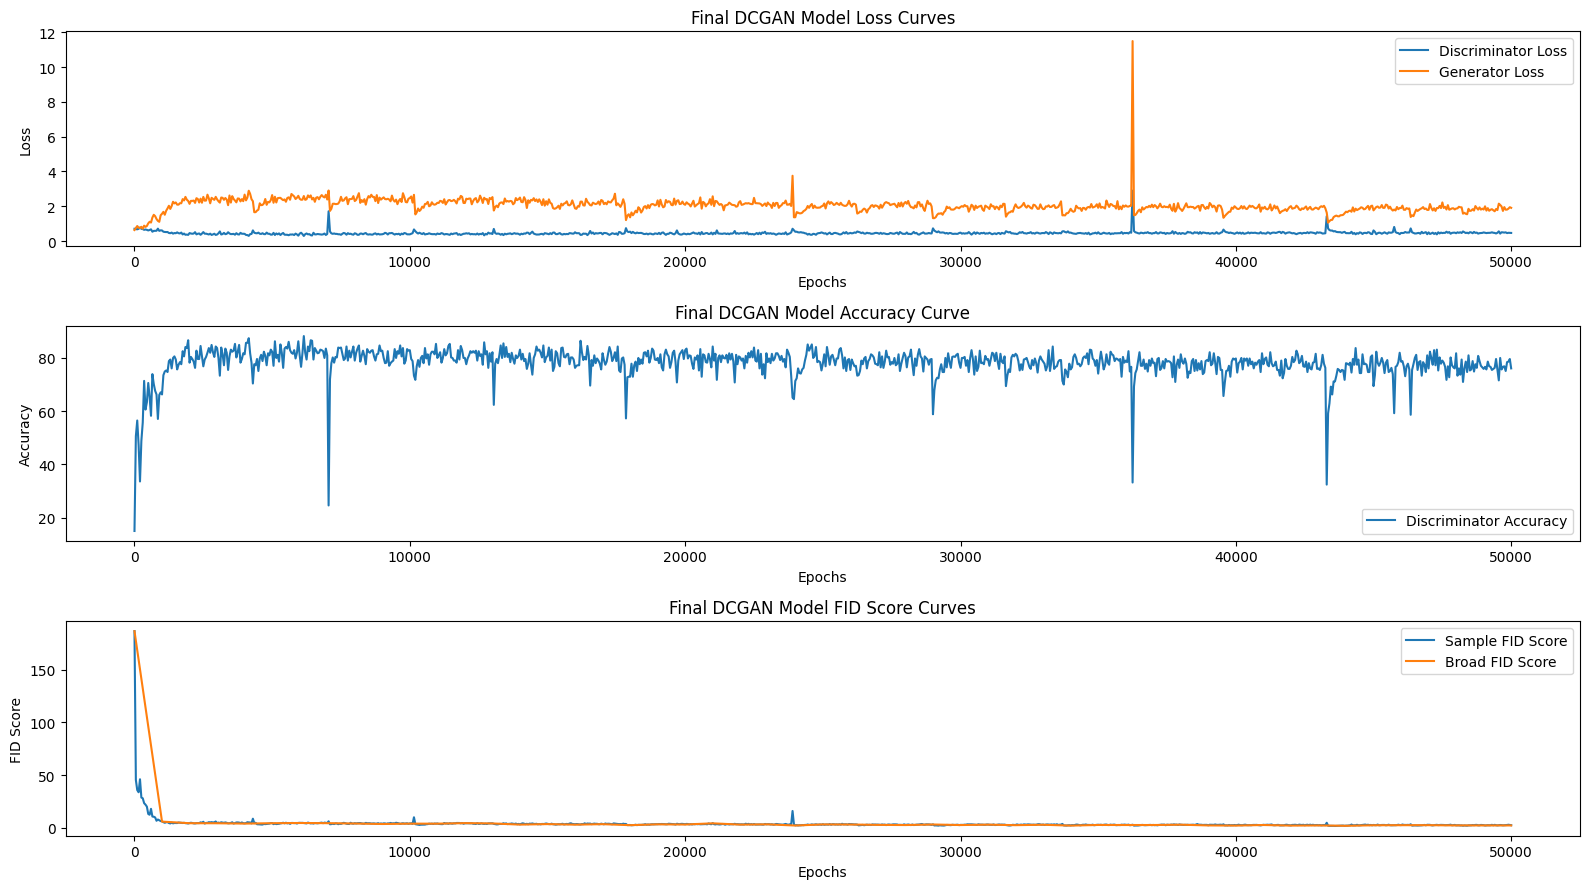

In [34]:
fig, ax = plt.subplots(3, 1, figsize=(16, 9))

ax[0].set_title('Final DCGAN Model Loss Curves')
ax[0].plot(dcgan.epochs, dcgan.discriminator_loss, label='Discriminator Loss')
ax[0].plot(dcgan.epochs, dcgan.generator_loss, label='Generator Loss')
ax[0].yaxis.set_label_text('Loss')
ax[0].xaxis.set_label_text('Epochs')
ax[0].legend()

ax[1].set_title('Final DCGAN Model Accuracy Curve')
ax[1].plot(dcgan.epochs, dcgan.discriminator_accuracy, label='Discriminator Accuracy')
ax[1].yaxis.set_label_text('Accuracy')
ax[1].xaxis.set_label_text('Epochs')
ax[1].legend()

ax[2].set_title('Final DCGAN Model FID Score Curves')
ax[2].plot(dcgan.epochs, dcgan.sample_fid_score, label='Sample FID Score')
ax[2].plot(dcgan.broad_fid_epochs, dcgan.broad_fid_score, label='Broad FID Score')
ax[2].yaxis.set_label_text('FID Score')
ax[2].xaxis.set_label_text('Epochs')
ax[2].legend()

fig.tight_layout()
plt.show()

In [35]:
print(f"Final DCGAN model final FID score at epoch {dcgan.broad_fid_epochs[-1]} is {dcgan.broad_fid_score[-1]}")

Final DCGAN model final FID score at epoch 49999 is 2.178942626148526


<b><u>Observation</u></b><br>
Looking at the FID score for the base DCGAN model, it is very unstable and fluctuates a lot. This shows that the performance of it is not very good.<br>
From the Final DCGAN model's FID score, it spiked down extremely quickly and continues to gradually decrease by the amount of epochs

<h2>Model Evaluation<h2><hr>

<b><u>Choosing An Epoch Weight</u></b><br>
Looking at the training images, it appears that the images at epoch 49950 looks the best and therefore we will use that epoch for our final model.

In [21]:
final_dcgan = DCGAN(28,28,1)

final_dcgan.generator.load_weights('generator_weights/generator_weights_49950.h5')

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 14, 14, 128)       1280      
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                                 
 dropout_6 (Dropout)         (None, 14, 14, 128)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 7, 7, 128)         147584    
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 7, 7, 128)         0         
                                                                 
 dropout_7 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 conv2d_8 (Conv2D)           (None, 4, 4, 128)        

<h3>Method 1: Eye-power<h3>

To see how good a model is, we can generate X amount of images and see what images out of the X amount would look nice or passable

2/2 [==============================] - 0s 23ms/step


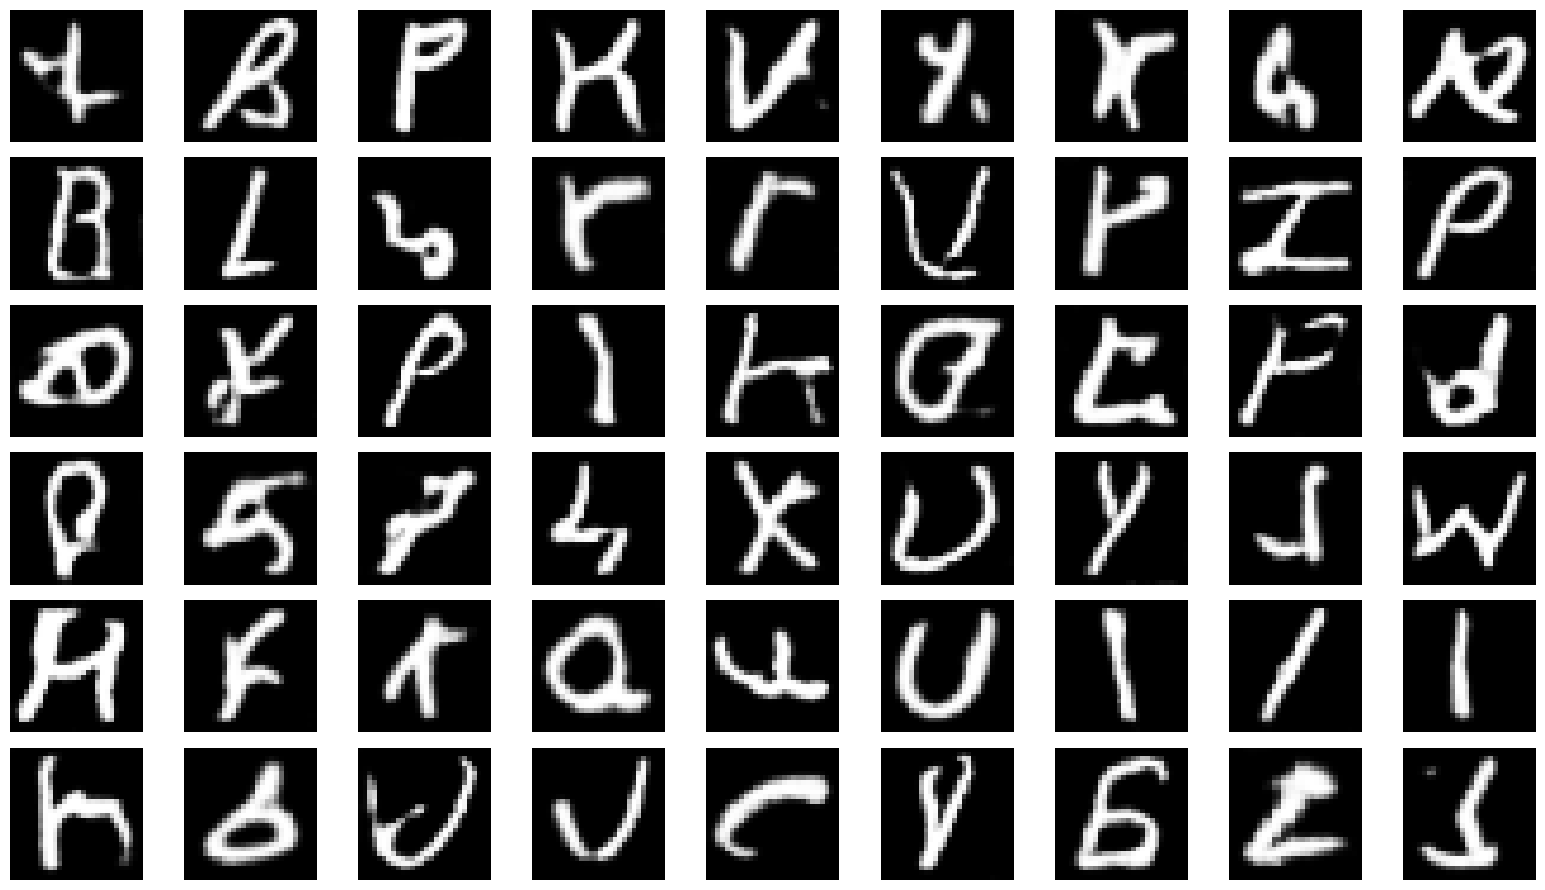

In [27]:
show_images(final_dcgan.generate_image(54), rows=6, cols=9, show_headers=False)

From the 54 images generated above, about 28 of those images are readable letters which is roughly 52% of the images generated

<h3>Method 2: FID<h3>

The Fréchet inception distance (FID) is a metric used to assess the quality of images created by a generative model. The FID compares the distribution of generated images with the distribution of a set of real images aka "ground truth". Classifiers that achieve the best (lowest) FID score tend to have greater sample variety.

In [23]:
final_dcgan.get_broad_fid()

2775/2775 [==============================] - 9s 3ms/step


2.2539265816636087

The model got an FID score of 2.25 which is considered good.

5/5 [==============================] - 0s 24ms/step


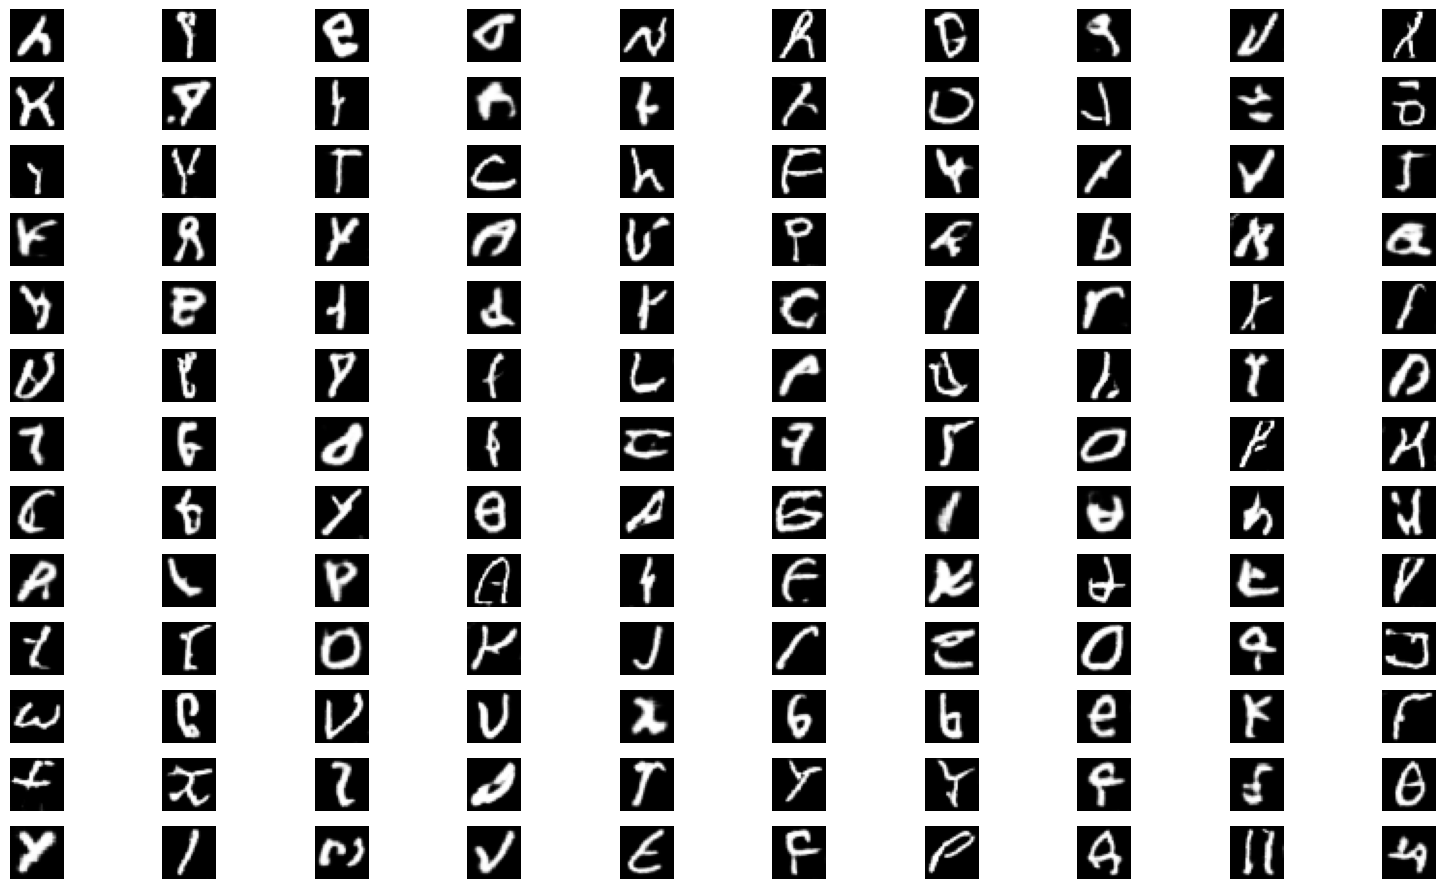

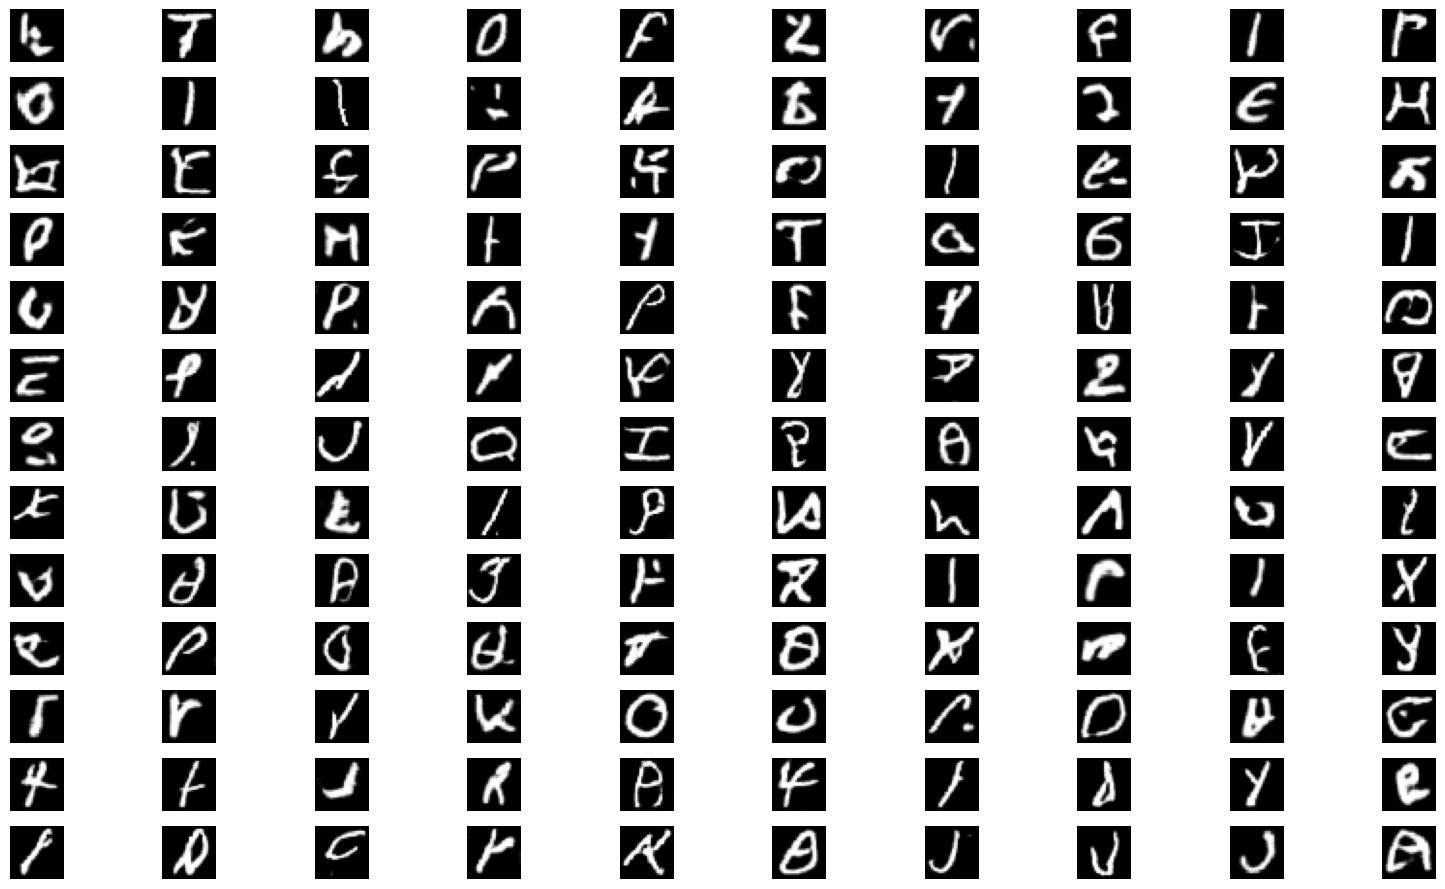

In [34]:
os.makedirs('final_images', exist_ok=True)

for i in range(2):
    final_model_images = final_dcgan.generate_image(130)
    show_images(final_model_images, rows=13, cols=10, show_headers=False, show_plot=False)
    plt.savefig(f'final_images/final_model_images_{i}.png')

<h2>Conclusion<h2><hr>

<b><u>If you are asked to generate images of a specific class, propose a way of doing it.<b></u><br>

To create images conditioned by specific classes, i would use conditional GANs (cGANs), where each label is associateed for each class/letter

<b><u>If you are asked to generate coloured images instead of black-and-white ones, do you
think it would be easier or harder to produce better quality results?<b></u>

Generating better quality coloured images would be more difficult as compared to BW ones.BW images have only one channel, while coloured images have 3(red,green,blue), making it more complex for the GAN model.Coloured images also have hue , saturation and brightness which will also make it even more complex.


<b><u>What class(es) is/are relatively easier/harder to generate? Why?<b></u>

Letter with simple shapes such as O and I are easy for the GAN model to generate.Xs , Ys and Cs also are easy too.This is because for letters like O, I and C , they have a very simple shape.For letters like X and Y , they do not look similar to other classes making it easier for the GAN to distinguish and generate.<br>Letters that are harder for the GAN model to produce are letters that look very similar to each other such as P , B and D , or letters that have a complex shape such as A and R